In [11]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [29]:
Disney = yf.download(tickers='DIS', start="2023-01-01", end="2023-03-31", rounding=True)
Disney = Disney["Close"].squeeze()
Disney

[*********************100%***********************]  1 of 1 completed


Date
2023-01-03    87.88
2023-01-04    90.86
2023-01-05    90.80
2023-01-06    92.77
2023-01-09    93.61
              ...  
2023-03-24    92.93
2023-03-27    94.45
2023-03-28    93.66
2023-03-29    95.69
2023-03-30    96.90
Name: DIS, Length: 61, dtype: float64

In [6]:
Disney.index = pd.to_datetime(Disney.index)
len_train = int(len(Disney)*0.7)
print("Base de entrenamiento: ", len_train)

len_test = int(len(Disney)*0.3)
print("Base de prueba: ", len_test)

Base de entrenamiento:  42
Base de prueba:  18


In [30]:
train = Disney[0:len_train]
test = Disney[len_train:]

[ 1.00000000e+00  8.93388411e-01  8.00584217e-01  7.00702207e-01
  6.16677232e-01  5.20399468e-01  4.09548147e-01  2.95682753e-01
  2.14306470e-01  1.15806493e-01 -2.15164454e-04 -1.11426521e-01
 -2.24162453e-01 -3.01178435e-01 -3.59935298e-01 -4.17865076e-01
 -4.41404738e-01]


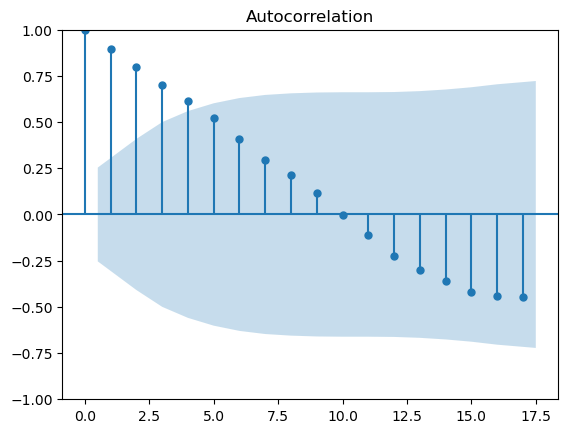

In [10]:
acf_array = acf(train)
print(acf_array)

# Grafico con un nivel de confianza del 90%
plot_acf(train, alpha=0.1)
plt.show()

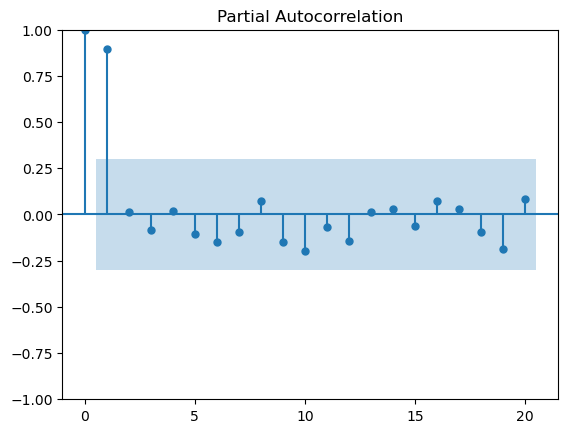

In [12]:
plot_pacf(train, lags=20)
plt.show()

Mediante la prueba de autocorrelacion parcial, podemos ver el cambio subito despues del valor 1, por lo que el modelo AR(1) parece ser el mas adecuado

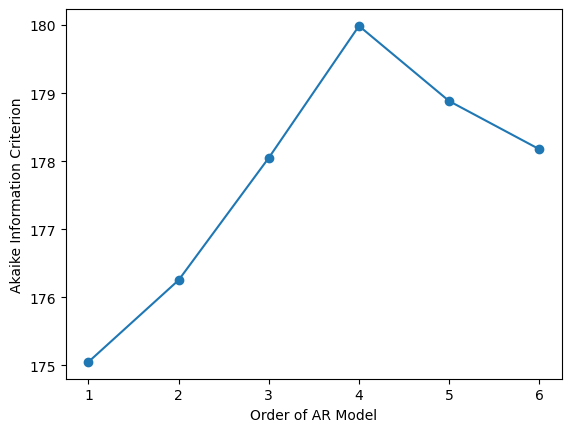

In [13]:
# Criterio Akaike
AIC=np.zeros(7)
for p in range(7):
    mod=ARIMA(train, order=(p, 0, 0))
    res = mod.fit()
# Save BIX for AR(p)
    AIC[p] = res.aic

# Plot the BIC as a function of p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Akaike Information Criterion')
plt.show()


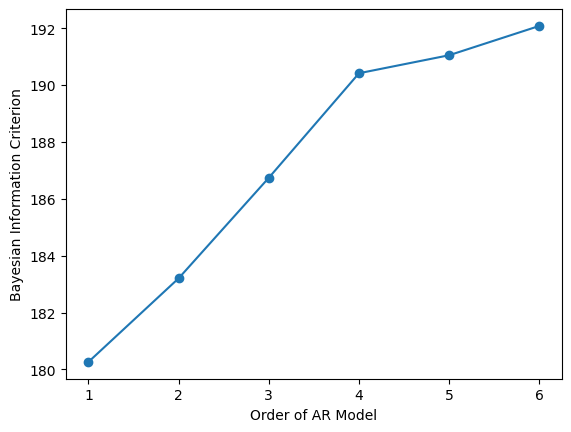

In [14]:
# Criterio Bayesiano
AIC=np.zeros(7)
for p in range(7):
    mod=ARIMA(train, order=(p, 0, 0))
    res = mod.fit()
# Save BIX for AR(p)
    AIC[p] = res.bic

# Plot the BIC as a function of p
plt.plot(range(1,7), AIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()


Los criterios Akaike y Bayesiano muestran que el modelo es mejor en un valor de 1

In [15]:
# Pronostico de los valores del mes de abril
predicciones = res.forecast(len(test) + 30)
predicciones.tail(5)

86    99.239581
87    99.251762
88    99.264188
89    99.276623
90    99.288925
Name: predicted_mean, dtype: float64

In [17]:
# Pronostico de los valores del mes de abril con in intervalo de confianza del 90%
conf = res.get_forecast(len(test) + 30).conf_int(alpha=0.1)
conf.tail(5)

,lower DIS,upper DIS
86,86.992211,111.486950
87,87.002039,111.501484
88,87.012782,111.515594
89,87.024071,111.529174
90,87.035644,111.542206


In [52]:
train = pd.DataFrame(train)
lista = pd.DataFrame(test)
lista = lista.reset_index()
lista = lista.drop("DIS", axis=1)
test = pd.DataFrame(test)

In [44]:
k = 17
lista2 = []
for day in range(1,18):
    fecha=((pd.to_datetime("2023-04-05") + pd.offsets.BDay(day)).date())
    lista2.append(fecha)
lista2 = pd.DataFrame(lista2, columns=["Date"])
lista2["Date"] = pd.to_datetime(lista2["Date"])
lista2

,Date
0,2023-04-06
1,2023-04-07
2,2023-04-10
3,2023-04-11
4,2023-04-12
5,2023-04-13
6,2023-04-14
7,2023-04-17
8,2023-04-18
9,2023-04-19


In [55]:
fechas = lista.append(lista2)
fechas = fechas.reset_index()
fechas.drop(columns=["index"] , inplace=True)

predicciones = pd.DataFrame(predicciones)
predicciones = predicciones.reset_index()
predicciones.drop(columns=["index"], inplace=True)

frames = [fechas, predicciones]
result = pd.concat(frames, axis=1, join = "inner")
result.columns = ['Date', 'Predicciones']

result.index = result["Date"]
result.drop(columns=["Date"], inplace=True)
result

,Predicciones
Date,
2023-03-06,99.855984
2023-03-07,99.502978
2023-03-08,99.316627
2023-03-09,99.936008
2023-03-10,100.477277
2023-03-13,100.386570
2023-03-14,100.230199
2023-03-15,100.280861
2023-03-16,100.517537


In [56]:
conf=conf.reset_index()
conf.drop(columns=["index"], inplace = True)
conf

,lower DIS,upper DIS
0,97.232504,102.479465
1,95.781375,103.224580
2,94.732390,103.900865
3,94.686287,105.185729
4,94.392297,106.562256
5,93.312502,107.460637
6,92.342963,108.117435
7,91.727996,108.833726
8,91.381845,109.653228
9,90.879177,110.292478


In [58]:
frames = [fechas, conf]
intervalos = pd.concat(frames, axis=1, join = 'inner')
intervalos.index = intervalos['Date']
intervalos.drop(columns=["Date"], inplace=True)
intervalos

,lower DIS,upper DIS
Date,,
2023-03-06,97.232504,102.479465
2023-03-07,95.781375,103.224580
2023-03-08,94.732390,103.900865
2023-03-09,94.686287,105.185729
2023-03-10,94.392297,106.562256
2023-03-13,93.312502,107.460637
2023-03-14,92.342963,108.117435
2023-03-15,91.727996,108.833726
2023-03-16,91.381845,109.653228


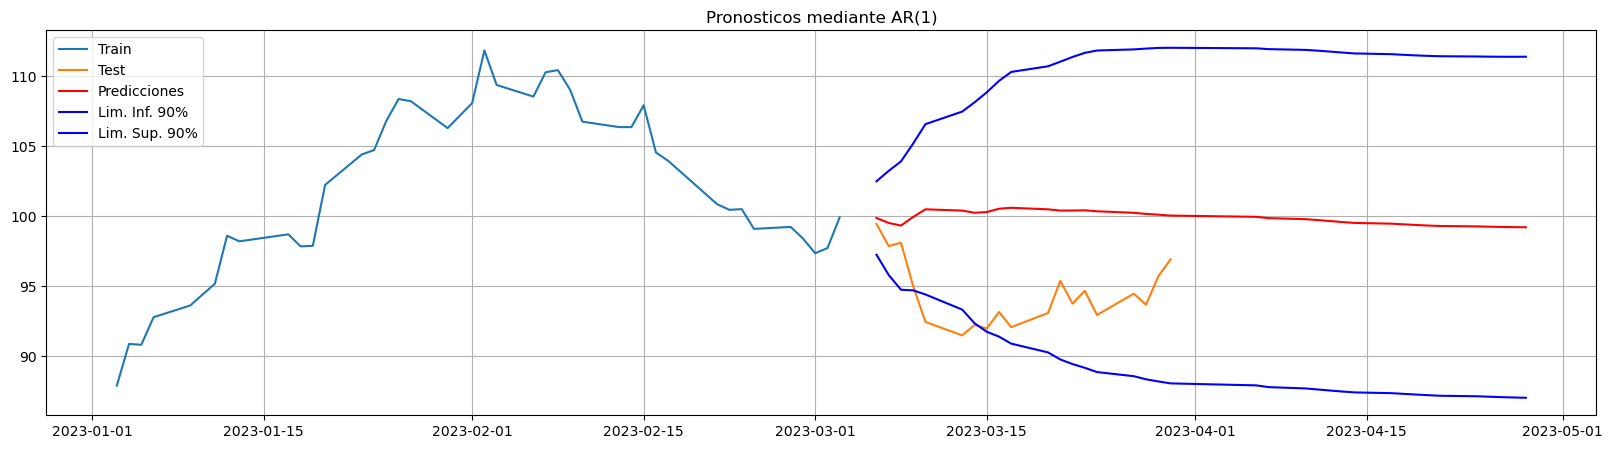

In [61]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(result, label = "Predicciones", color = "red")
plt.plot(intervalos['lower DIS'], label = "Lim. Inf. 90%", color = "blue")
plt.plot(intervalos['upper DIS'], label = "Lim. Sup. 90%", color = "blue")
plt.legend(loc="best")
plt.title("Pronosticos mediante AR(1)")
plt.show()

In [68]:
acumulador1 = 0
acumulador2 = 0

for contador in range(0, 19):
    acumulador1 = acumulador1 + (test.iloc[contador][0] - predicciones.iloc[contador][0]) ** 2
    acumulador2 = acumulador2 + np.abs((test.iloc[contador][0] - predicciones.iloc[contador][0]) /
                                       test.iloc[contador][0])
mse = acumulador1 / 19
rmse = np.round(np.sqrt(mse),2)
mape = np.round((acumulador2 / 19) * 100,2)
print("RMSE =", rmse, "MAPE = ", mape, "%")       

RMSE = 6.29 MAPE =  6.17 %


Con estos valores podemos concluir que nuestro pronostico puede esta 6.17% equivocado y que en promedio, nuestros valores estan alejados por 6.29 dolares del valor real